In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

mu = pd.read_csv("MU.txt", delimiter='\t')
mu.columns = ['id','event','device','channel','code','size','data']
mw = pd.read_csv("MW.txt", delimiter='\t')
mw.columns = ['id','event','device','channel','code','size','data']

In [2]:
print(mu["channel"].value_counts())
print(mu["code"].value_counts())
print(mu["size"].value_counts())

channel
FP1     40983
FP2     40983
TP10    40983
TP9     40982
Name: count, dtype: int64
code
-1    44412
 6    12367
 8    12208
 7    12080
 5    12052
 9    11988
 2    11920
 0    11904
 3    11832
 1    11632
 4    11536
Name: count, dtype: int64
size
476    51272
460    44432
459    32815
493    18504
442     9584
       ...  
524        4
445        4
451        4
498        4
509        4
Name: count, Length: 69, dtype: int64


In [3]:
print(mw["channel"].value_counts())
print(mw["code"].value_counts())
print(mw["size"].value_counts())

channel
FP1    67634
Name: count, dtype: int64
code
-1    12701
 5     5568
 7     5552
 8     5545
 0     5530
 2     5517
 1     5498
 6     5476
 9     5450
 3     5416
 4     5381
Name: count, dtype: int64
size
952     14403
953     13610
1024    12701
1017     8824
1015     8617
889      6445
951      1068
1016      820
1014      597
888       530
825         7
826         5
763         2
504         1
441         1
569         1
890         1
700         1
Name: count, dtype: int64


In [7]:
def parse_sig(s):
    return np.array([float(x) for x in s.split(',') if x != ''])

# ---- Bandpass filter ----
def bandpass(sig, fs=256, low=1, high=40, order=4):
    nyq = fs / 2
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    if len(sig) > (order * 3):
        return filtfilt(b, a, sig)
    return sig

def interp_sig(sig, out_len):
    if len(sig) == out_len:
        return sig
    x_old = np.linspace(0, 1, len(sig))
    x_new = np.linspace(0, 1, out_len)
    return interp1d(x_old, sig, kind='linear')(x_new)

def fill_nan(sig):
    sig = np.array(sig, dtype=float)
    if np.any(np.isnan(sig)):
        idx = np.arange(len(sig))
        sig[np.isnan(sig)] = np.interp(idx[np.isnan(sig)], idx[~np.isnan(sig)], sig[~np.isnan(sig)])
    return sig

# ---- Normalize ----
def norm(sig):
    return MinMaxScaler().fit_transform(sig.reshape(-1, 1)).flatten()
def process_single_channel(df, target_channel, fs=256):

    channel_data = df[df['channel'] == target_channel]
    trials = []
    for trial_id, group in channel_data.groupby('id'):
        sig = parse_sig(group.iloc[0]['data'])
        sig = fill_nan(sig)
        sig = bandpass(sig, fs)
        trials.append(sig)

    if not trials:
        return np.array([])
    target_len = int(np.median([len(sig) for sig in trials]))
    processed = []
    for sig in trials:
        processed.append(norm(interp_sig(sig, target_len)))

    return np.array(processed)

# MU dataset
tp9 = process_single_channel(mu, 'TP9')
tp10 = process_single_channel(mu, 'TP10')

# MW dataset
fp1 = process_single_channel(mw, 'FP1')

print("TP9 shape:", tp9.shape)
print("TP10 shape:", tp10.shape)
print("FP1 shape:", fp1.shape)


TP9 shape: (40982, 460)
TP10 shape: (40983, 460)
FP1 shape: (67634, 953)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


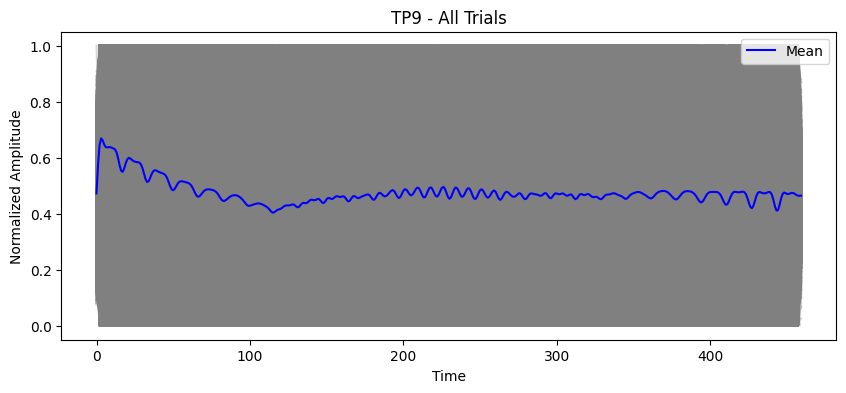

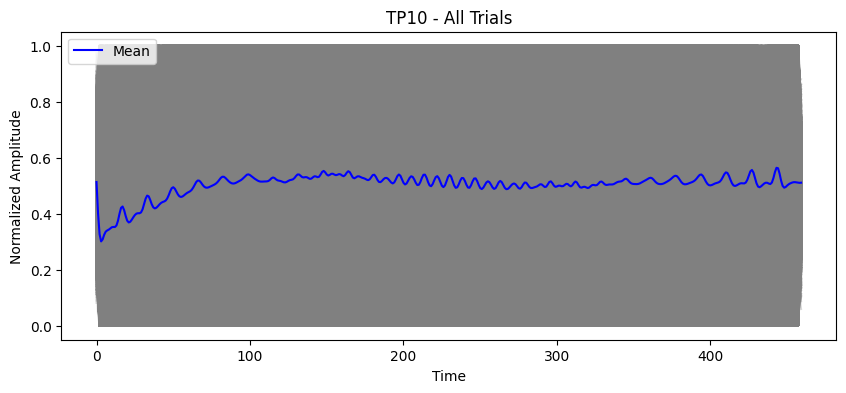

In [8]:
# ---- Plotting ----
def plot_channel(data, channel_name):
    plt.figure(figsize=(10,4))
    for trial in data:
        plt.plot(trial, alpha=0.3, color='gray')
    plt.plot(np.mean(data, axis=0), color='blue', label='Mean')
    plt.title(f"{channel_name} - All Trials")
    plt.xlabel("Time")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.show()

plot_channel(tp9, "TP9")
plot_channel(tp10, "TP10")

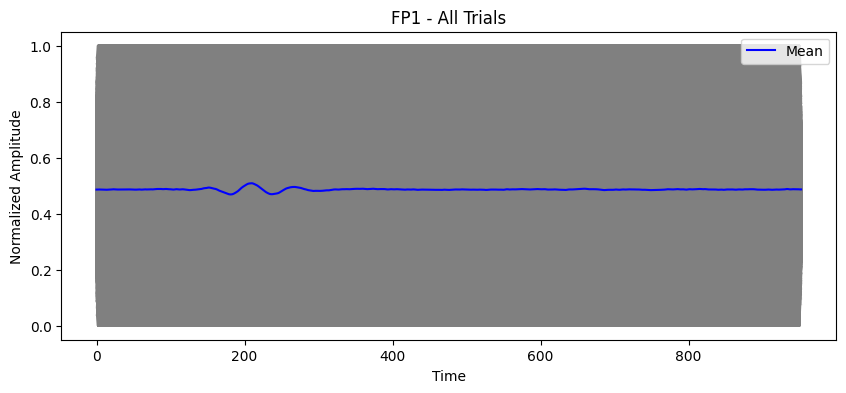

In [6]:
plot_channel(fp1, "FP1")